In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 2

In [3]:

#Load dataset
def load_dataset(path=r'yahoo_stock.csv'):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [5]:
def prepare_data(df):
  df_aux = df.drop(columns=['High', 'Low', 'Volume', 'Adj Close'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux

In [6]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['Open']] = scaler.fit_transform(df[['Open']])
  df[['Close']] = scaler.fit_transform(df[['Close']])
  return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [8]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [9]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 1])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
  #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'yahoo_model.png', show_shapes=True)
  return model

In [12]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [13]:
#Main Execution
#the dataframes
df_raw = load_dataset()
#Get data from 2015 to the end of 2018
df_raw = df_raw[:1134]
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    #inp= np.append(inp[0],[[yhat[0][0],yhat[0][1]]],axis=0) #adiciona previsão recente ao input
    #inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  print(forecasts)
  return forecasts

In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data['Open'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Yahoo stock price')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

                }
# record da history de cada modelo
record = {}

Epoch 1/10
51/51 [==============================] - 5s 31ms/step - loss: 0.2906 - mae: 0.2881 - rmse: 0.2906 - val_loss: 0.0245 - val_mae: 0.0232 - val_rmse: 0.0239
Epoch 2/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1225 - mae: 0.1184 - rmse: 0.1224 - val_loss: 0.0137 - val_mae: 0.0119 - val_rmse: 0.0132
Epoch 3/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1973 - mae: 0.1938 - rmse: 0.1973 - val_loss: 0.0665 - val_mae: 0.0660 - val_rmse: 0.0672
Epoch 4/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1206 - mae: 0.1146 - rmse: 0.1206 - val_loss: 0.0847 - val_mae: 0.0810 - val_rmse: 0.0853
Epoch 5/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1144 - mae: 0.1061 - rmse: 0.1144 - val_loss: 0.0753 - val_mae: 0.0681 - val_rmse: 0.0758

Epoch 00005: val_loss improved from inf to 0.07526, saving model to my_model_5_0.075.h5
Epoch 6/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1297 - mae: 0.12

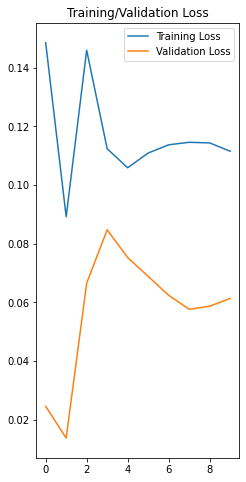

Epoch 1/10
102/102 [==============================] - 1s 9ms/step - loss: 0.0918 - mae: 0.0886 - rmse: 0.0916 - val_loss: 0.0285 - val_mae: 0.0258 - val_rmse: 0.0290
Epoch 2/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1213 - mae: 0.1171 - rmse: 0.1208 - val_loss: 0.0412 - val_mae: 0.0392 - val_rmse: 0.0420
Epoch 3/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1003 - mae: 0.0979 - rmse: 0.1000 - val_loss: 0.0332 - val_mae: 0.0307 - val_rmse: 0.0338
Epoch 4/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0898 - mae: 0.0871 - rmse: 0.0894 - val_loss: 0.0383 - val_mae: 0.0362 - val_rmse: 0.0390
Epoch 5/10
102/102 [==============================] - 1s 9ms/step - loss: 0.0830 - mae: 0.0806 - rmse: 0.0827 - val_loss: 0.0320 - val_mae: 0.0294 - val_rmse: 0.0325

Epoch 00005: val_loss improved from 0.06132 to 0.03197, saving model to my_model_5_0.032.h5
Epoch 6/10
102/102 [==============================] - 1s 9ms/step - loss: 0.0

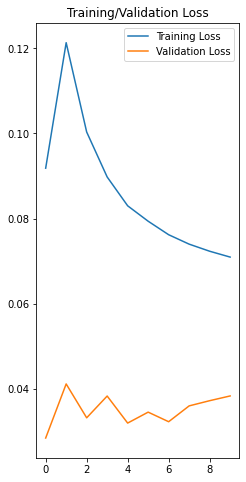

Epoch 1/10
152/152 [==============================] - 3s 7ms/step - loss: 0.0579 - mae: 0.0541 - rmse: 0.0579 - val_loss: 0.0869 - val_mae: 0.0744 - val_rmse: 0.0878
Epoch 2/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0467 - mae: 0.0425 - rmse: 0.0467 - val_loss: 0.0936 - val_mae: 0.0846 - val_rmse: 0.0939
Epoch 3/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0468 - mae: 0.0417 - rmse: 0.0468 - val_loss: 0.0905 - val_mae: 0.0819 - val_rmse: 0.0909
Epoch 4/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0479 - mae: 0.0440 - rmse: 0.0479 - val_loss: 0.0807 - val_mae: 0.0714 - val_rmse: 0.0814
Epoch 5/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0464 - mae: 0.0427 - rmse: 0.0464 - val_loss: 0.0773 - val_mae: 0.0684 - val_rmse: 0.0781

Epoch 00005: val_loss did not improve from 0.03197
Epoch 6/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0458 - mae: 0.0419 - rmse: 0.0458 - val_lo

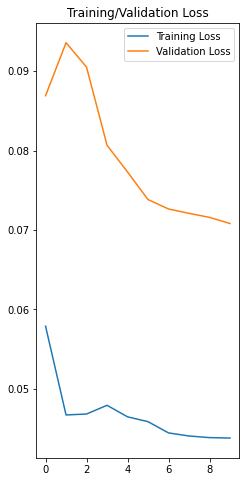

[array([[2508.4658, 2508.7278]], dtype=float32)]
[array([[2508.4658, 2508.7278]], dtype=float32)]
[2508.4658]


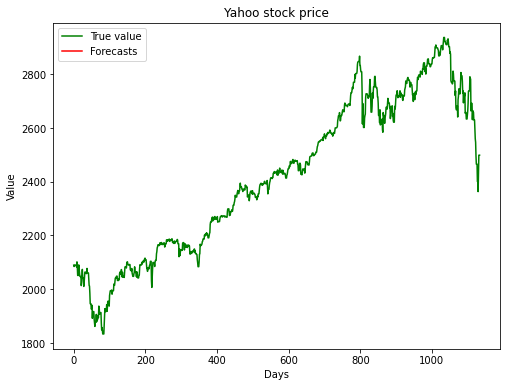

Epoch 1/50
51/51 [==============================] - 5s 25ms/step - loss: 0.3291 - mae: 0.3233 - rmse: 0.3290 - val_loss: 0.0249 - val_mae: 0.0236 - val_rmse: 0.0242
Epoch 2/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1688 - mae: 0.1628 - rmse: 0.1688 - val_loss: 0.0630 - val_mae: 0.0541 - val_rmse: 0.0636
Epoch 3/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1411 - mae: 0.1336 - rmse: 0.1411 - val_loss: 0.0936 - val_mae: 0.0931 - val_rmse: 0.0942
Epoch 4/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1140 - mae: 0.1083 - rmse: 0.1140 - val_loss: 0.0904 - val_mae: 0.0895 - val_rmse: 0.0910
Epoch 5/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1204 - mae: 0.1157 - rmse: 0.1204 - val_loss: 0.0941 - val_mae: 0.0929 - val_rmse: 0.0947

Epoch 00005: val_loss improved from inf to 0.09413, saving model to my_model_5_0.094.h5
Epoch 6/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1227 - mae: 0.11

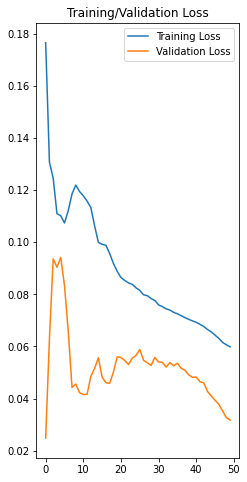

Epoch 1/50
102/102 [==============================] - 1s 10ms/step - loss: 0.0454 - mae: 0.0420 - rmse: 0.0452 - val_loss: 0.0230 - val_mae: 0.0196 - val_rmse: 0.0219
Epoch 2/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0489 - mae: 0.0456 - rmse: 0.0487 - val_loss: 0.0203 - val_mae: 0.0167 - val_rmse: 0.0193
Epoch 3/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0467 - mae: 0.0434 - rmse: 0.0465 - val_loss: 0.0165 - val_mae: 0.0133 - val_rmse: 0.0161
Epoch 4/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0449 - mae: 0.0415 - rmse: 0.0447 - val_loss: 0.0163 - val_mae: 0.0133 - val_rmse: 0.0162
Epoch 5/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0435 - mae: 0.0400 - rmse: 0.0433 - val_loss: 0.0162 - val_mae: 0.0134 - val_rmse: 0.0164

Epoch 00005: val_loss improved from 0.03181 to 0.01619, saving model to my_model_5_0.016.h5
Epoch 6/50
102/102 [==============================] - 1s 9ms/step - loss: 0.

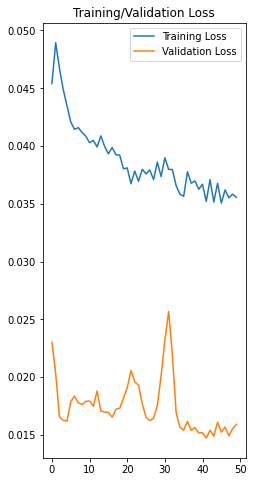

Epoch 1/50
152/152 [==============================] - 3s 8ms/step - loss: 0.0293 - mae: 0.0254 - rmse: 0.0293 - val_loss: 0.0570 - val_mae: 0.0482 - val_rmse: 0.0574
Epoch 2/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0312 - mae: 0.0275 - rmse: 0.0312 - val_loss: 0.0645 - val_mae: 0.0566 - val_rmse: 0.0648
Epoch 3/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0336 - mae: 0.0302 - rmse: 0.0336 - val_loss: 0.0636 - val_mae: 0.0560 - val_rmse: 0.0639
Epoch 4/50
152/152 [==============================] - 1s 8ms/step - loss: 0.0341 - mae: 0.0307 - rmse: 0.0341 - val_loss: 0.0737 - val_mae: 0.0663 - val_rmse: 0.0738
Epoch 5/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0300 - mae: 0.0263 - rmse: 0.0300 - val_loss: 0.0573 - val_mae: 0.0482 - val_rmse: 0.0579

Epoch 00005: val_loss did not improve from 0.01516
Epoch 6/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0284 - mae: 0.0245 - rmse: 0.0284 - val_lo

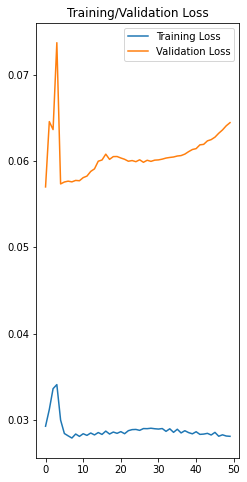

[array([[2522.6223, 2521.3574]], dtype=float32)]
[array([[2522.6223, 2521.3574]], dtype=float32)]
[2522.6223]


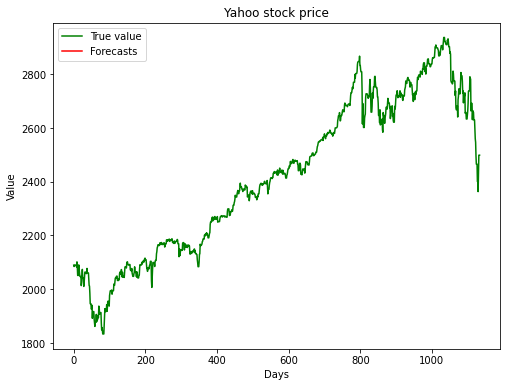

Epoch 1/100
51/51 [==============================] - 5s 27ms/step - loss: 0.3404 - mae: 0.3357 - rmse: 0.3403 - val_loss: 0.0212 - val_mae: 0.0180 - val_rmse: 0.0213
Epoch 2/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1521 - mae: 0.1457 - rmse: 0.1520 - val_loss: 0.0653 - val_mae: 0.0603 - val_rmse: 0.0659
Epoch 3/100
51/51 [==============================] - 1s 10ms/step - loss: 0.1330 - mae: 0.1260 - rmse: 0.1330 - val_loss: 0.0930 - val_mae: 0.0918 - val_rmse: 0.0936
Epoch 4/100
51/51 [==============================] - 1s 10ms/step - loss: 0.1099 - mae: 0.1039 - rmse: 0.1099 - val_loss: 0.0915 - val_mae: 0.0905 - val_rmse: 0.0921
Epoch 5/100
51/51 [==============================] - 1s 10ms/step - loss: 0.1164 - mae: 0.1112 - rmse: 0.1164 - val_loss: 0.0917 - val_mae: 0.0906 - val_rmse: 0.0923

Epoch 00005: val_loss improved from inf to 0.09173, saving model to my_model_5_0.092.h5
Epoch 6/100
51/51 [==============================] - 0s 10ms/step - loss: 0.1209 -

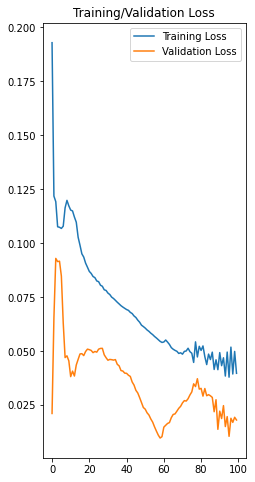

Epoch 1/100
102/102 [==============================] - 1s 11ms/step - loss: 0.0391 - mae: 0.0353 - rmse: 0.0389 - val_loss: 0.0304 - val_mae: 0.0266 - val_rmse: 0.0319
Epoch 2/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0419 - mae: 0.0381 - rmse: 0.0416 - val_loss: 0.0177 - val_mae: 0.0141 - val_rmse: 0.0178
Epoch 3/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0423 - mae: 0.0385 - rmse: 0.0421 - val_loss: 0.0206 - val_mae: 0.0175 - val_rmse: 0.0213
Epoch 4/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0398 - mae: 0.0359 - rmse: 0.0396 - val_loss: 0.0171 - val_mae: 0.0140 - val_rmse: 0.0175
Epoch 5/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0386 - mae: 0.0347 - rmse: 0.0384 - val_loss: 0.0152 - val_mae: 0.0121 - val_rmse: 0.0152

Epoch 00005: val_loss did not improve from 0.01044
Epoch 6/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0390 - mae: 0.0350 - rmse: 0.0

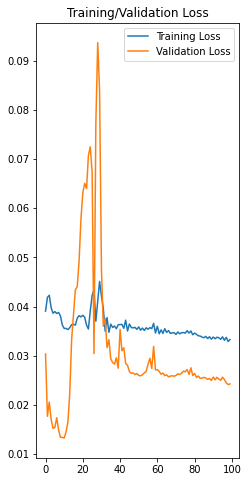

Epoch 1/100
152/152 [==============================] - 3s 8ms/step - loss: 0.0294 - mae: 0.0255 - rmse: 0.0294 - val_loss: 0.0668 - val_mae: 0.0607 - val_rmse: 0.0668
Epoch 2/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0287 - mae: 0.0247 - rmse: 0.0287 - val_loss: 0.0493 - val_mae: 0.0385 - val_rmse: 0.0500
Epoch 3/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0284 - mae: 0.0243 - rmse: 0.0284 - val_loss: 0.0655 - val_mae: 0.0589 - val_rmse: 0.0656
Epoch 4/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0283 - mae: 0.0244 - rmse: 0.0283 - val_loss: 0.0486 - val_mae: 0.0382 - val_rmse: 0.0492
Epoch 5/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0250 - mae: 0.0211 - rmse: 0.0250 - val_loss: 0.0595 - val_mae: 0.0523 - val_rmse: 0.0597

Epoch 00005: val_loss did not improve from 0.01044
Epoch 6/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0260 - mae: 0.0219 - rmse: 0.0260 - 

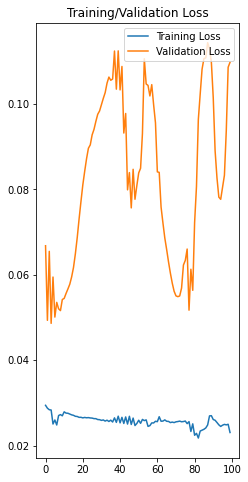

[array([[2519.677, 2518.921]], dtype=float32)]
[array([[2519.677, 2518.921]], dtype=float32)]
[2519.677]


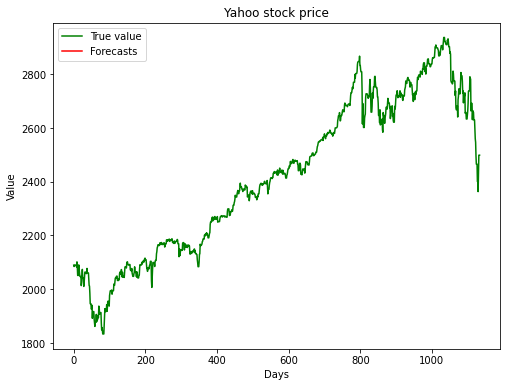

Epoch 1/60
51/51 [==============================] - 5s 27ms/step - loss: 0.2700 - mae: 0.2638 - rmse: 0.2700 - val_loss: 0.0255 - val_mae: 0.0244 - val_rmse: 0.0248
Epoch 2/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1253 - mae: 0.1179 - rmse: 0.1253 - val_loss: 0.0262 - val_mae: 0.0251 - val_rmse: 0.0256
Epoch 3/60
51/51 [==============================] - 1s 10ms/step - loss: 0.1997 - mae: 0.1946 - rmse: 0.1996 - val_loss: 0.0686 - val_mae: 0.0639 - val_rmse: 0.0692
Epoch 4/60
51/51 [==============================] - 1s 10ms/step - loss: 0.1358 - mae: 0.1296 - rmse: 0.1358 - val_loss: 0.0884 - val_mae: 0.0880 - val_rmse: 0.0890
Epoch 5/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1191 - mae: 0.1137 - rmse: 0.1191 - val_loss: 0.0876 - val_mae: 0.0871 - val_rmse: 0.0883

Epoch 00005: val_loss improved from inf to 0.08764, saving model to my_model_5_0.088.h5
Epoch 6/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1220 - mae:

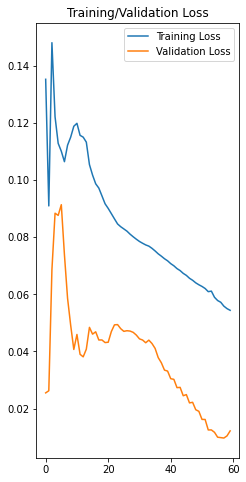

Epoch 1/60
102/102 [==============================] - 1s 11ms/step - loss: 0.0387 - mae: 0.0353 - rmse: 0.0385 - val_loss: 0.0183 - val_mae: 0.0152 - val_rmse: 0.0184
Epoch 2/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0475 - mae: 0.0441 - rmse: 0.0471 - val_loss: 0.0174 - val_mae: 0.0141 - val_rmse: 0.0170
Epoch 3/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0446 - mae: 0.0408 - rmse: 0.0443 - val_loss: 0.0275 - val_mae: 0.0230 - val_rmse: 0.0268
Epoch 4/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0450 - mae: 0.0415 - rmse: 0.0447 - val_loss: 0.0222 - val_mae: 0.0189 - val_rmse: 0.0212
Epoch 5/60
102/102 [==============================] - 1s 11ms/step - loss: 0.0457 - mae: 0.0423 - rmse: 0.0454 - val_loss: 0.0230 - val_mae: 0.0195 - val_rmse: 0.0227

Epoch 00005: val_loss did not improve from 0.01168
Epoch 6/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0451 - mae: 0.0413 - rmse: 0.0449 - 

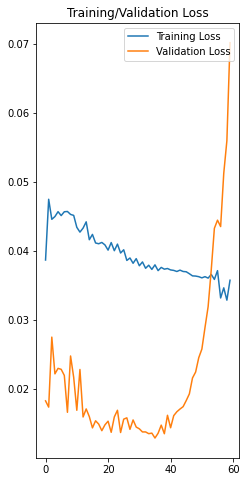

Epoch 1/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0328 - mae: 0.0293 - rmse: 0.0328 - val_loss: 0.0672 - val_mae: 0.0605 - val_rmse: 0.0674
Epoch 2/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0276 - mae: 0.0235 - rmse: 0.0276 - val_loss: 0.0693 - val_mae: 0.0626 - val_rmse: 0.0696
Epoch 3/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0272 - mae: 0.0230 - rmse: 0.0272 - val_loss: 0.0590 - val_mae: 0.0507 - val_rmse: 0.0596
Epoch 4/60
152/152 [==============================] - 1s 10ms/step - loss: 0.0283 - mae: 0.0241 - rmse: 0.0282 - val_loss: 0.0626 - val_mae: 0.0547 - val_rmse: 0.0630
Epoch 5/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0289 - mae: 0.0252 - rmse: 0.0289 - val_loss: 0.0570 - val_mae: 0.0480 - val_rmse: 0.0575

Epoch 00005: val_loss did not improve from 0.01168
Epoch 6/60
152/152 [==============================] - 1s 10ms/step - loss: 0.0269 - mae: 0.0230 - rmse: 0.0269 - 

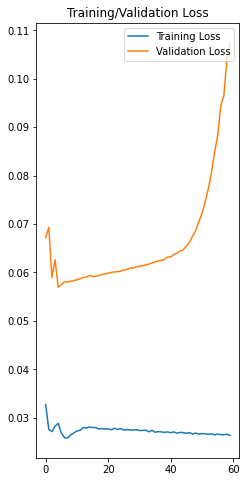

[array([[2512.0022, 2511.2297]], dtype=float32)]
[array([[2512.0022, 2511.2297]], dtype=float32)]
[2512.0022]


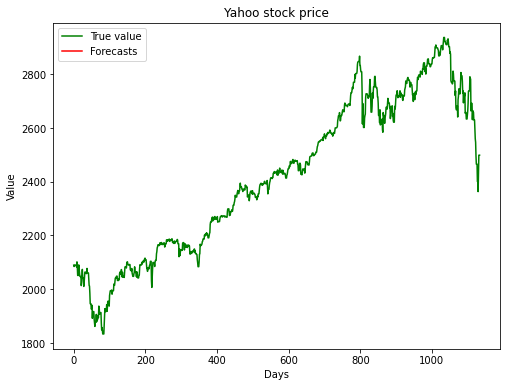

Epoch 1/90
51/51 [==============================] - 5s 28ms/step - loss: 0.2589 - mae: 0.2556 - rmse: 0.2588 - val_loss: 0.0239 - val_mae: 0.0226 - val_rmse: 0.0232
Epoch 2/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1436 - mae: 0.1404 - rmse: 0.1436 - val_loss: 0.0208 - val_mae: 0.0189 - val_rmse: 0.0213
Epoch 3/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1592 - mae: 0.1561 - rmse: 0.1592 - val_loss: 0.0831 - val_mae: 0.0822 - val_rmse: 0.0838
Epoch 4/90
51/51 [==============================] - 1s 12ms/step - loss: 0.1182 - mae: 0.1127 - rmse: 0.1182 - val_loss: 0.0772 - val_mae: 0.0765 - val_rmse: 0.0778
Epoch 5/90
51/51 [==============================] - 1s 12ms/step - loss: 0.1196 - mae: 0.1136 - rmse: 0.1196 - val_loss: 0.0794 - val_mae: 0.0789 - val_rmse: 0.0801

Epoch 00005: val_loss improved from inf to 0.07945, saving model to my_model_5_0.079.h5
Epoch 6/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1211 - mae:

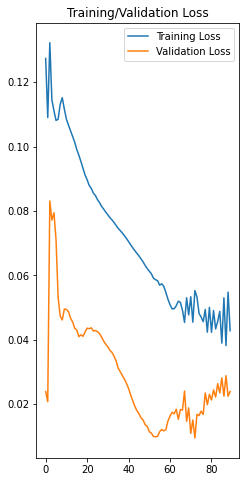

Epoch 1/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0369 - mae: 0.0327 - rmse: 0.0368 - val_loss: 0.0383 - val_mae: 0.0343 - val_rmse: 0.0408
Epoch 2/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0405 - mae: 0.0369 - rmse: 0.0403 - val_loss: 0.0223 - val_mae: 0.0175 - val_rmse: 0.0233
Epoch 3/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0378 - mae: 0.0339 - rmse: 0.0376 - val_loss: 0.0273 - val_mae: 0.0231 - val_rmse: 0.0287
Epoch 4/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0431 - mae: 0.0396 - rmse: 0.0428 - val_loss: 0.0203 - val_mae: 0.0163 - val_rmse: 0.0208
Epoch 5/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0397 - mae: 0.0355 - rmse: 0.0395 - val_loss: 0.0203 - val_mae: 0.0165 - val_rmse: 0.0214

Epoch 00005: val_loss did not improve from 0.01000
Epoch 6/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0357 - mae: 0.0308 - rmse: 0.0355 - 

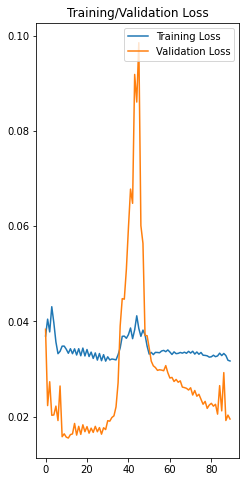

Epoch 1/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0277 - mae: 0.0237 - rmse: 0.0277 - val_loss: 0.0682 - val_mae: 0.0599 - val_rmse: 0.0685
Epoch 2/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0266 - mae: 0.0226 - rmse: 0.0266 - val_loss: 0.0796 - val_mae: 0.0727 - val_rmse: 0.0797
Epoch 3/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0273 - mae: 0.0235 - rmse: 0.0273 - val_loss: 0.0711 - val_mae: 0.0634 - val_rmse: 0.0713
Epoch 4/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0267 - mae: 0.0230 - rmse: 0.0267 - val_loss: 0.0753 - val_mae: 0.0682 - val_rmse: 0.0754
Epoch 5/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0249 - mae: 0.0211 - rmse: 0.0249 - val_loss: 0.0684 - val_mae: 0.0595 - val_rmse: 0.0687

Epoch 00005: val_loss did not improve from 0.01000
Epoch 6/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0232 - mae: 0.0192 - rmse: 0.0232 - 

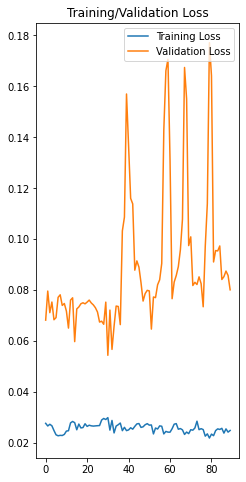

[array([[2514.2522, 2512.6826]], dtype=float32)]
[array([[2514.2522, 2512.6826]], dtype=float32)]
[2514.2522]


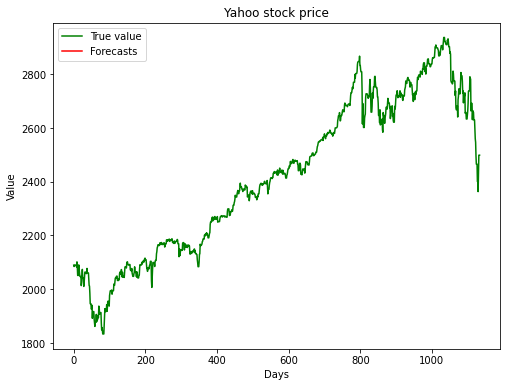

Epoch 1/120
51/51 [==============================] - 5s 28ms/step - loss: 0.2435 - mae: 0.2409 - rmse: 0.2435 - val_loss: 0.0221 - val_mae: 0.0209 - val_rmse: 0.0214
Epoch 2/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1234 - mae: 0.1196 - rmse: 0.1234 - val_loss: 0.0112 - val_mae: 0.0093 - val_rmse: 0.0110
Epoch 3/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1801 - mae: 0.1772 - rmse: 0.1801 - val_loss: 0.0812 - val_mae: 0.0806 - val_rmse: 0.0819
Epoch 4/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1164 - mae: 0.1105 - rmse: 0.1164 - val_loss: 0.0793 - val_mae: 0.0774 - val_rmse: 0.0799
Epoch 5/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1176 - mae: 0.1107 - rmse: 0.1176 - val_loss: 0.0736 - val_mae: 0.0691 - val_rmse: 0.0742

Epoch 00005: val_loss improved from inf to 0.07359, saving model to my_model_5_0.074.h5
Epoch 6/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1287 

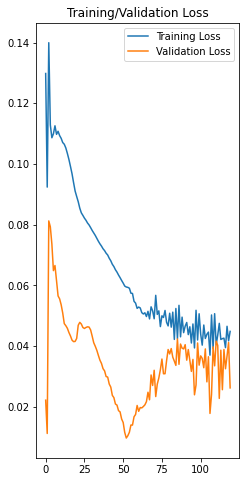

Epoch 1/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0347 - mae: 0.0306 - rmse: 0.0346 - val_loss: 0.0262 - val_mae: 0.0226 - val_rmse: 0.0277
Epoch 2/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0357 - mae: 0.0317 - rmse: 0.0356 - val_loss: 0.0235 - val_mae: 0.0207 - val_rmse: 0.0245
Epoch 3/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0396 - mae: 0.0356 - rmse: 0.0394 - val_loss: 0.0174 - val_mae: 0.0142 - val_rmse: 0.0180
Epoch 4/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0385 - mae: 0.0345 - rmse: 0.0383 - val_loss: 0.0151 - val_mae: 0.0120 - val_rmse: 0.0152
Epoch 5/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0370 - mae: 0.0329 - rmse: 0.0367 - val_loss: 0.0147 - val_mae: 0.0112 - val_rmse: 0.0141

Epoch 00005: val_loss did not improve from 0.01157
Epoch 6/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0366 - mae: 0.0325 - rmse: 0.0

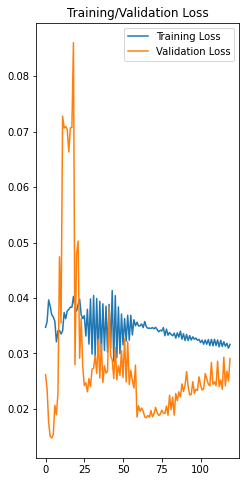

Epoch 1/120
152/152 [==============================] - 2s 12ms/step - loss: 0.0300 - mae: 0.0259 - rmse: 0.0300 - val_loss: 0.0962 - val_mae: 0.0895 - val_rmse: 0.0960
Epoch 2/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0271 - mae: 0.0231 - rmse: 0.0271 - val_loss: 0.0711 - val_mae: 0.0632 - val_rmse: 0.0713
Epoch 3/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0247 - mae: 0.0205 - rmse: 0.0247 - val_loss: 0.0680 - val_mae: 0.0592 - val_rmse: 0.0684
Epoch 4/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0250 - mae: 0.0208 - rmse: 0.0250 - val_loss: 0.0687 - val_mae: 0.0605 - val_rmse: 0.0690
Epoch 5/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0247 - mae: 0.0206 - rmse: 0.0247 - val_loss: 0.0761 - val_mae: 0.0699 - val_rmse: 0.0762

Epoch 00005: val_loss did not improve from 0.01157
Epoch 6/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0240 - mae: 0.0199 - rmse: 0.0

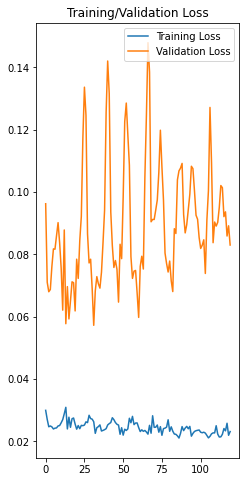

[array([[2511.5022, 2511.4612]], dtype=float32)]
[array([[2511.5022, 2511.4612]], dtype=float32)]
[2511.5022]


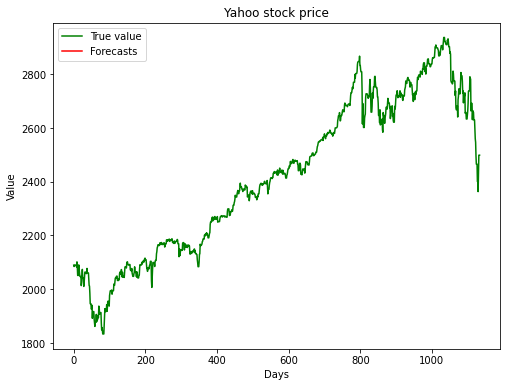

Epoch 1/50
32/32 [==============================] - 5s 60ms/step - loss: 0.3936 - mae: 0.3901 - rmse: 0.3935 - val_loss: 0.0375 - val_mae: 0.0306 - val_rmse: 0.0403
Epoch 2/50
32/32 [==============================] - 1s 16ms/step - loss: 0.1262 - mae: 0.1182 - rmse: 0.1261 - val_loss: 0.0399 - val_mae: 0.0361 - val_rmse: 0.0416
Epoch 3/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1220 - mae: 0.1145 - rmse: 0.1220 - val_loss: 0.0346 - val_mae: 0.0326 - val_rmse: 0.0369
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1274 - mae: 0.1217 - rmse: 0.1273 - val_loss: 0.0224 - val_mae: 0.0189 - val_rmse: 0.0272
Epoch 5/50
32/32 [==============================] - 0s 16ms/step - loss: 0.1475 - mae: 0.1424 - rmse: 0.1475 - val_loss: 0.0243 - val_mae: 0.0202 - val_rmse: 0.0300

Epoch 00005: val_loss improved from inf to 0.02432, saving model to my_model_5_0.024.h5
Epoch 6/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1455 - mae:

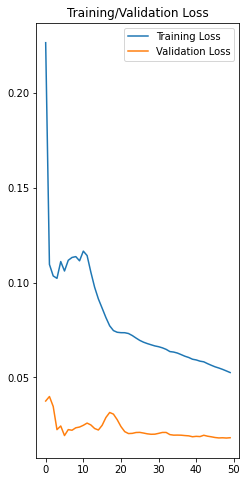

Epoch 1/50
64/64 [==============================] - 2s 27ms/step - loss: 0.0388 - mae: 0.0340 - rmse: 0.0388 - val_loss: 0.0328 - val_mae: 0.0288 - val_rmse: 0.0328
Epoch 2/50
64/64 [==============================] - 1s 15ms/step - loss: 0.0410 - mae: 0.0360 - rmse: 0.0410 - val_loss: 0.0320 - val_mae: 0.0286 - val_rmse: 0.0320
Epoch 3/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0413 - mae: 0.0362 - rmse: 0.0413 - val_loss: 0.0325 - val_mae: 0.0293 - val_rmse: 0.0325
Epoch 4/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0421 - mae: 0.0369 - rmse: 0.0420 - val_loss: 0.0329 - val_mae: 0.0298 - val_rmse: 0.0329
Epoch 5/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0418 - mae: 0.0366 - rmse: 0.0418 - val_loss: 0.0331 - val_mae: 0.0302 - val_rmse: 0.0331

Epoch 00005: val_loss did not improve from 0.01813
Epoch 6/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0420 - mae: 0.0367 - rmse: 0.0419 - val_loss: 0.

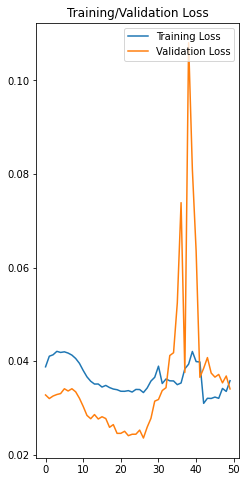

Epoch 1/50
95/95 [==============================] - 1s 15ms/step - loss: 0.0326 - mae: 0.0287 - rmse: 0.0326 - val_loss: 0.0539 - val_mae: 0.0451 - val_rmse: 0.0585
Epoch 2/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0300 - mae: 0.0258 - rmse: 0.0300 - val_loss: 0.0632 - val_mae: 0.0548 - val_rmse: 0.0681
Epoch 3/50
95/95 [==============================] - 1s 14ms/step - loss: 0.0269 - mae: 0.0222 - rmse: 0.0269 - val_loss: 0.0653 - val_mae: 0.0560 - val_rmse: 0.0668
Epoch 4/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0274 - mae: 0.0230 - rmse: 0.0274 - val_loss: 0.0494 - val_mae: 0.0397 - val_rmse: 0.0529
Epoch 5/50
95/95 [==============================] - 1s 14ms/step - loss: 0.0253 - mae: 0.0206 - rmse: 0.0252 - val_loss: 0.0533 - val_mae: 0.0434 - val_rmse: 0.0558

Epoch 00005: val_loss did not improve from 0.01813
Epoch 6/50
95/95 [==============================] - 1s 14ms/step - loss: 0.0322 - mae: 0.0283 - rmse: 0.0322 - val_loss: 0.

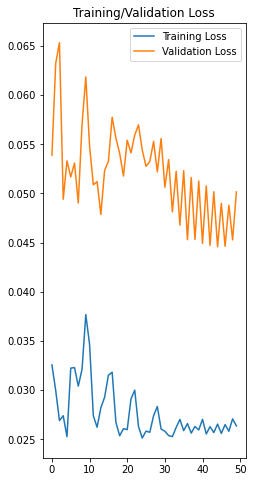

[array([[2502.1255, 2503.6692]], dtype=float32)]
[array([[2502.1255, 2503.6692]], dtype=float32)]
[2502.1255]


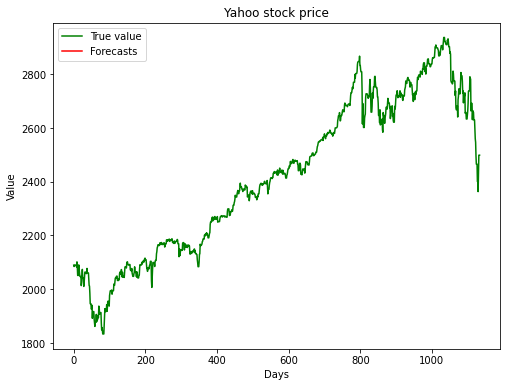

Epoch 1/90
32/32 [==============================] - 4s 42ms/step - loss: 0.3767 - mae: 0.3667 - rmse: 0.3767 - val_loss: 0.0634 - val_mae: 0.0527 - val_rmse: 0.0633
Epoch 2/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1168 - mae: 0.1094 - rmse: 0.1167 - val_loss: 0.0421 - val_mae: 0.0410 - val_rmse: 0.0432
Epoch 3/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1178 - mae: 0.1118 - rmse: 0.1178 - val_loss: 0.0328 - val_mae: 0.0304 - val_rmse: 0.0354
Epoch 4/90
32/32 [==============================] - 1s 16ms/step - loss: 0.1296 - mae: 0.1241 - rmse: 0.1296 - val_loss: 0.0192 - val_mae: 0.0160 - val_rmse: 0.0248
Epoch 5/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1521 - mae: 0.1475 - rmse: 0.1521 - val_loss: 0.0212 - val_mae: 0.0164 - val_rmse: 0.0274

Epoch 00005: val_loss improved from inf to 0.02121, saving model to my_model_5_0.021.h5
Epoch 6/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1455 - mae:

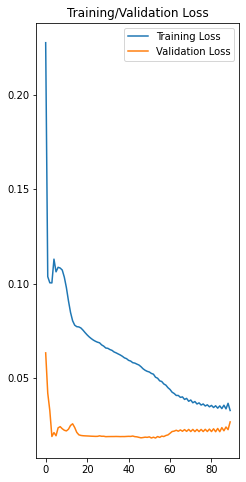

Epoch 1/90
64/64 [==============================] - 2s 25ms/step - loss: 0.0329 - mae: 0.0283 - rmse: 0.0331 - val_loss: 0.0286 - val_mae: 0.0253 - val_rmse: 0.0286
Epoch 2/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0365 - mae: 0.0323 - rmse: 0.0367 - val_loss: 0.0516 - val_mae: 0.0499 - val_rmse: 0.0516
Epoch 3/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0452 - mae: 0.0414 - rmse: 0.0452 - val_loss: 0.0390 - val_mae: 0.0371 - val_rmse: 0.0390
Epoch 4/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0375 - mae: 0.0338 - rmse: 0.0375 - val_loss: 0.0331 - val_mae: 0.0310 - val_rmse: 0.0331
Epoch 5/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0369 - mae: 0.0331 - rmse: 0.0369 - val_loss: 0.0322 - val_mae: 0.0300 - val_rmse: 0.0322

Epoch 00005: val_loss did not improve from 0.01869
Epoch 6/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0370 - mae: 0.0332 - rmse: 0.0369 - val_loss: 0.

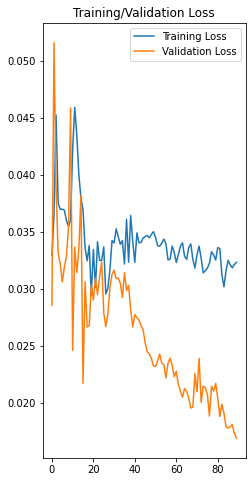

Epoch 1/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0292 - mae: 0.0247 - rmse: 0.0291 - val_loss: 0.0453 - val_mae: 0.0362 - val_rmse: 0.0487
Epoch 2/90
95/95 [==============================] - 1s 12ms/step - loss: 0.0292 - mae: 0.0248 - rmse: 0.0292 - val_loss: 0.0558 - val_mae: 0.0457 - val_rmse: 0.0575
Epoch 3/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0297 - mae: 0.0257 - rmse: 0.0297 - val_loss: 0.0631 - val_mae: 0.0549 - val_rmse: 0.0670
Epoch 4/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0290 - mae: 0.0244 - rmse: 0.0289 - val_loss: 0.0473 - val_mae: 0.0357 - val_rmse: 0.0495
Epoch 5/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0282 - mae: 0.0241 - rmse: 0.0281 - val_loss: 0.0457 - val_mae: 0.0363 - val_rmse: 0.0491

Epoch 00005: val_loss did not improve from 0.01690
Epoch 6/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0296 - mae: 0.0252 - rmse: 0.0296 - val_loss: 0.

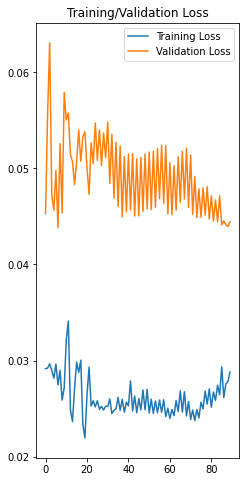

[array([[2487.6653, 2487.2766]], dtype=float32)]
[array([[2487.6653, 2487.2766]], dtype=float32)]
[2487.6653]


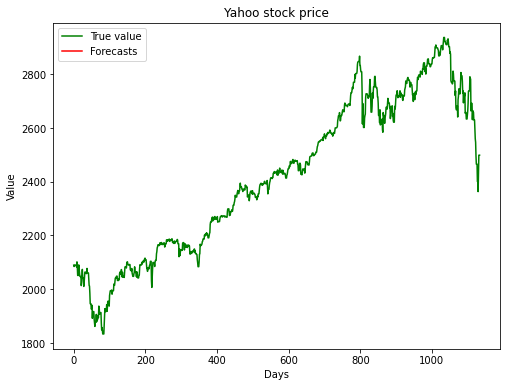

Epoch 1/120
32/32 [==============================] - 5s 59ms/step - loss: 0.3732 - mae: 0.3674 - rmse: 0.3731 - val_loss: 0.0384 - val_mae: 0.0348 - val_rmse: 0.0423
Epoch 2/120
32/32 [==============================] - 0s 14ms/step - loss: 0.1354 - mae: 0.1260 - rmse: 0.1354 - val_loss: 0.0292 - val_mae: 0.0268 - val_rmse: 0.0323
Epoch 3/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1211 - mae: 0.1131 - rmse: 0.1210 - val_loss: 0.0220 - val_mae: 0.0178 - val_rmse: 0.0271
Epoch 4/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1323 - mae: 0.1269 - rmse: 0.1323 - val_loss: 0.0206 - val_mae: 0.0165 - val_rmse: 0.0267
Epoch 5/120
32/32 [==============================] - 0s 14ms/step - loss: 0.1362 - mae: 0.1311 - rmse: 0.1362 - val_loss: 0.0212 - val_mae: 0.0167 - val_rmse: 0.0273

Epoch 00005: val_loss improved from inf to 0.02116, saving model to my_model_5_0.021.h5
Epoch 6/120
32/32 [==============================] - 0s 14ms/step - loss: 0.1358 

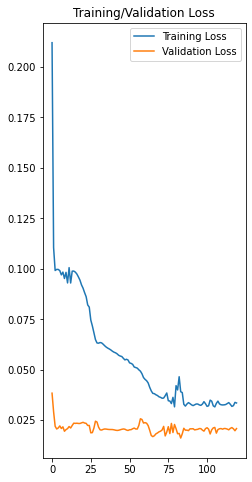

Epoch 1/120
64/64 [==============================] - 2s 27ms/step - loss: 0.0280 - mae: 0.0233 - rmse: 0.0280 - val_loss: 0.0237 - val_mae: 0.0198 - val_rmse: 0.0237
Epoch 2/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0311 - mae: 0.0264 - rmse: 0.0311 - val_loss: 0.0258 - val_mae: 0.0219 - val_rmse: 0.0258
Epoch 3/120
64/64 [==============================] - 1s 13ms/step - loss: 0.0329 - mae: 0.0276 - rmse: 0.0328 - val_loss: 0.0190 - val_mae: 0.0150 - val_rmse: 0.0190
Epoch 4/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0333 - mae: 0.0288 - rmse: 0.0332 - val_loss: 0.0214 - val_mae: 0.0180 - val_rmse: 0.0214
Epoch 5/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0354 - mae: 0.0308 - rmse: 0.0353 - val_loss: 0.0196 - val_mae: 0.0156 - val_rmse: 0.0196

Epoch 00005: val_loss did not improve from 0.01742
Epoch 6/120
64/64 [==============================] - 1s 15ms/step - loss: 0.0332 - mae: 0.0281 - rmse: 0.0331 - val_lo

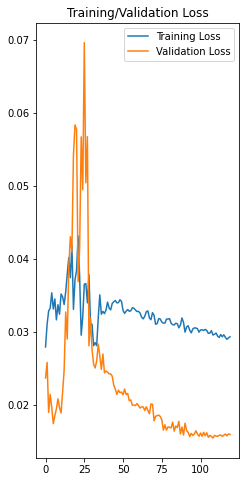

Epoch 1/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0252 - mae: 0.0205 - rmse: 0.0252 - val_loss: 0.0683 - val_mae: 0.0616 - val_rmse: 0.0687
Epoch 2/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0256 - mae: 0.0211 - rmse: 0.0256 - val_loss: 0.0517 - val_mae: 0.0418 - val_rmse: 0.0544
Epoch 3/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0225 - mae: 0.0179 - rmse: 0.0225 - val_loss: 0.0679 - val_mae: 0.0607 - val_rmse: 0.0686
Epoch 4/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0246 - mae: 0.0201 - rmse: 0.0246 - val_loss: 0.0526 - val_mae: 0.0419 - val_rmse: 0.0561
Epoch 5/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0246 - mae: 0.0200 - rmse: 0.0246 - val_loss: 0.0533 - val_mae: 0.0439 - val_rmse: 0.0555

Epoch 00005: val_loss did not improve from 0.01571
Epoch 6/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0257 - mae: 0.0214 - rmse: 0.0257 - val_lo

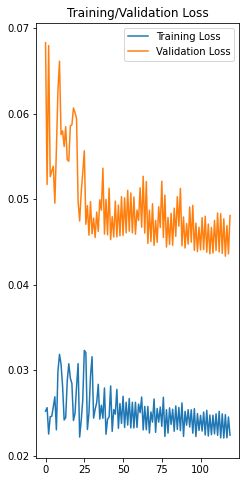

[array([[2499.048 , 2496.9016]], dtype=float32)]
[array([[2499.048 , 2496.9016]], dtype=float32)]
[2499.048]


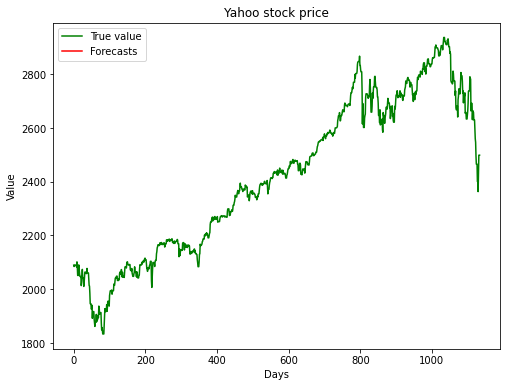

In [17]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  path_to_save=r'modelo_aux_close_'+str(t)+'.h5'
  model.save(path_to_save)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [18]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [19]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.0831213337679704, 0.07923190047343572, 0.0829624372224013, 0.05716630316649874, 0.05254454485451182, 0.05774097486088673] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.05224010657519102, 0.04830127652734518, 0.052158684233824415, 0.043429536179949844, 0.03930179913217823, 0.04397617115328709] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.043808722471197444, 0.039509812047084175, 0.043773746943722165, 0.049413267991816, 0.045967413230488696, 0.0496499616963168] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.0504261190071702, 0.04660491435271171, 0.050270833188874854, 0.04186471823809875, 0.038099030798508064, 0.042076500691473485] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.04380887044524704, 0.039675196756919225, 0.043690828392627064, 0.048995034831265605, 0.04529414232

In [20]:
final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.083121,0.079232,0.082962,0.057166,0.052545,0.057741
2,0.052240,0.048301,0.052159,0.043430,0.039302,0.043976
3,0.043809,0.039510,0.043774,0.049413,0.045967,0.049650
4,0.050426,0.046605,0.050271,0.041865,0.038099,0.042077
5,0.043809,0.039675,0.043691,0.048995,0.045294,0.049148
6,0.041194,0.036985,0.041127,0.050623,0.047077,0.050865
7,0.048166,0.043206,0.047992,0.036817,0.031440,0.039314
8,0.040429,0.035431,0.040261,0.032311,0.026751,0.034952
9,0.037624,0.032622,0.037470,0.031113,0.025398,0.033527


In [21]:
final_df.to_csv(r"resultados_close.csv",index=True)